# Аренда велосипедов за период 2011-2012г.г.

In [ ]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib

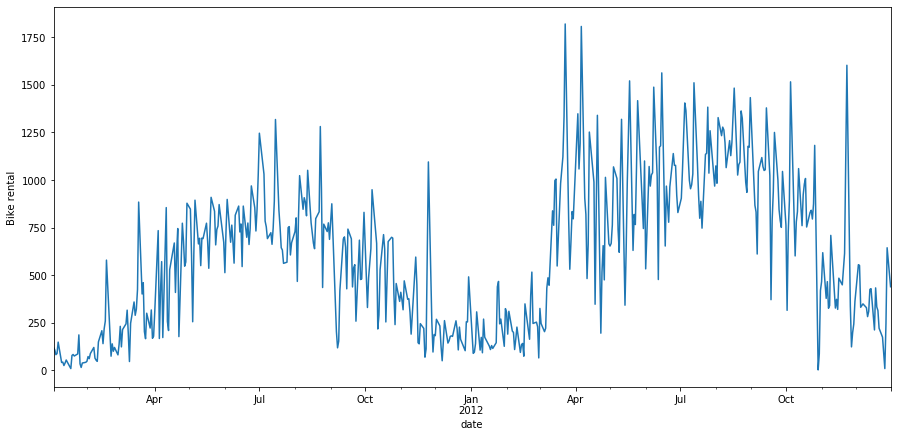

In [10]:
bike = pd.read_csv('C:/Users/irina/Desktop/DA_NEW/Datasets/bikes.csv',',', index_col=['date'], parse_dates=['date'], dayfirst=True)
plt.figure(figsize(15,7))
bike.count=bike['count']
bike.count.plot()
plt.ylabel('Bike rental')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

 Критерий Дики-Фуллера: p=0.203653


<Figure size 1080x720 with 0 Axes>

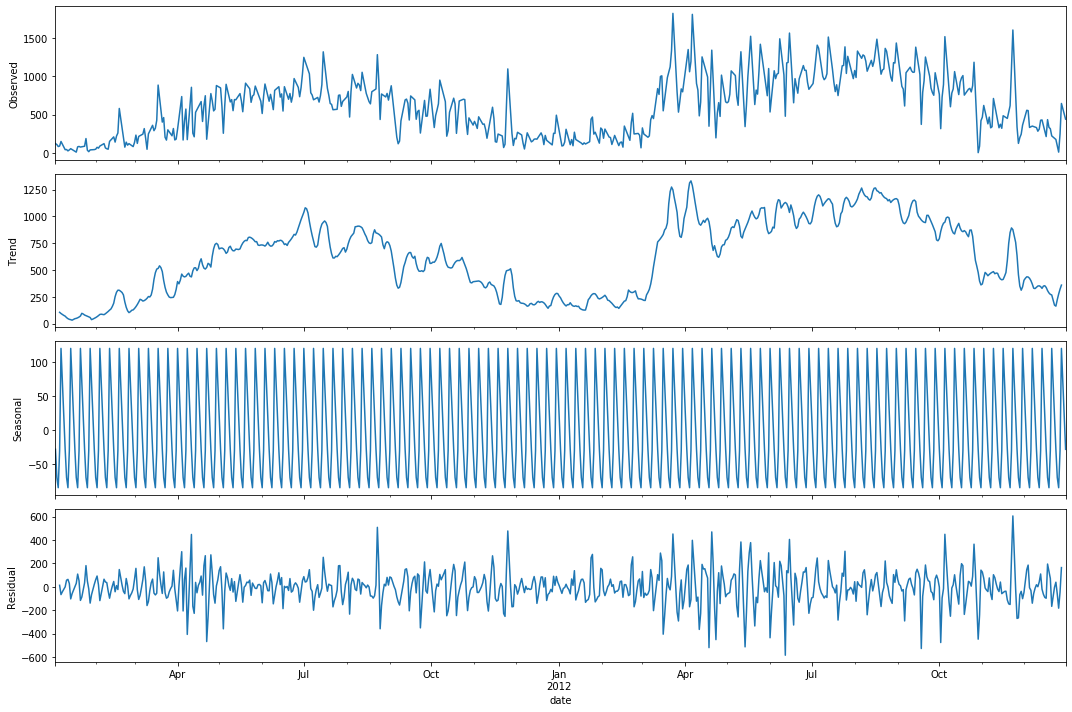

In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bike.count).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bike.count)[1])

### Стабилизация дисперсии

Делаем преобразование Кокса- бокса для стабилизации дисперсии:

Оптимальный параметр преобразования Кокса- Бокса: 0.577641
 Критерий Дики-Фуллера: p=0.147631


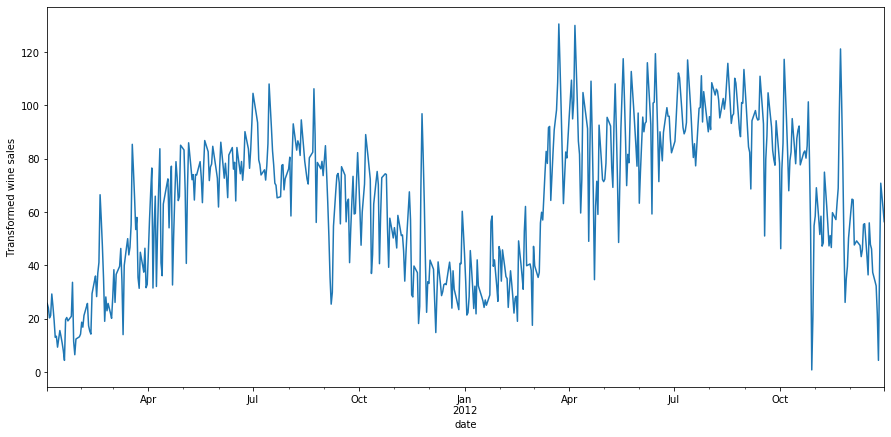

In [12]:
bike['count_box'], lmbda = stats.boxcox(bike.count)
plt.figure(figsize(15,7))
bike.count_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bike.count_box)[1])

### Стационарность


Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:


In [1]:
bike['count_box_diff'] = bike.count_box - bike.count_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bike.count_box_diff[12:]).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bike.count_box_diff[12:])[1])

NameError: name 'bike' is not defined

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить еще обычное дифференцирование:

 Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

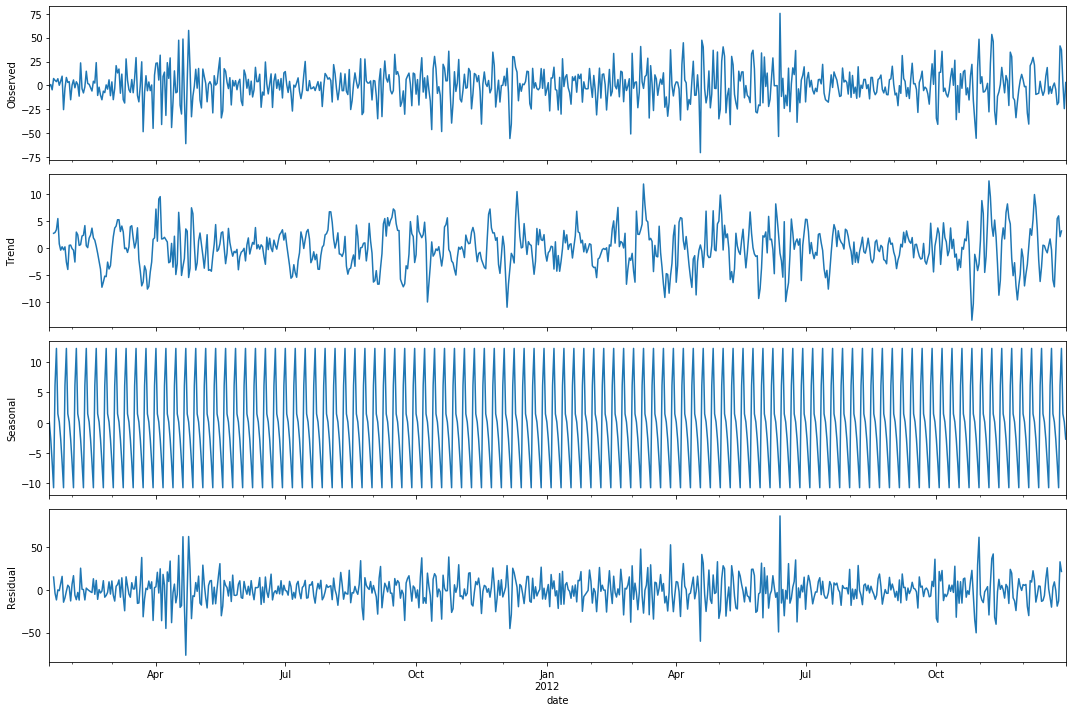

In [14]:
bike['count_box_diff2'] = bike.count_box_diff - bike.count_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(bike.count_box_diff2[13:]).plot()   
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(bike.count_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше тренда больше нет

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

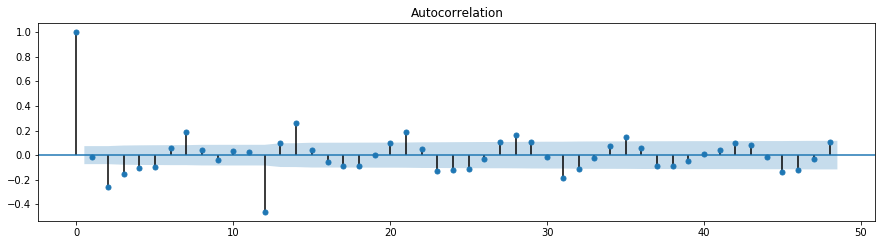

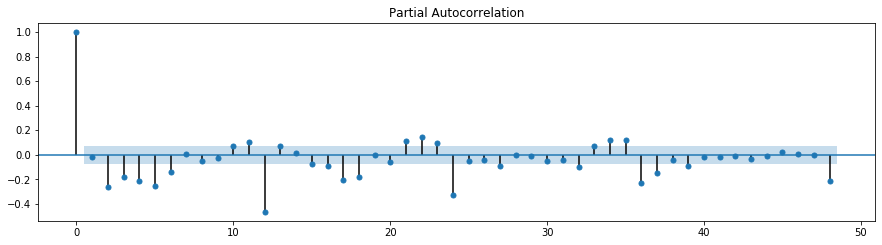

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(bike.count_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(bike.count_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближений: Q=1, q=2, P=1, p=4

In [18]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучаетс¤
    try:
        model=sm.tsa.statespace.SARIMAX(bike.count_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 14min 56s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
33  (2, 2, 0, 1)  5542.373113
35  (2, 2, 1, 1)  5542.395998
53  (4, 1, 0, 1)  5543.072225
55  (4, 1, 1, 1)  5543.345296
47  (3, 2, 1, 1)  5544.289881


Лучшая модель:

In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          count_box   No. Observations:                  729
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -2765.187
Date:                            Tue, 03 Mar 2020   AIC                           5542.373
Time:                                    19:05:50   BIC                           5569.815
Sample:                                01-03-2011   HQIC                          5552.970
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0694      0.135      7.949      0.000       0.806       1.333
ar.L2         -0.4825      0.085   

Остатки:

 Критерий Стьюдента: p=0.380114
 Критерий Дики-Фуллера: p=0.000000


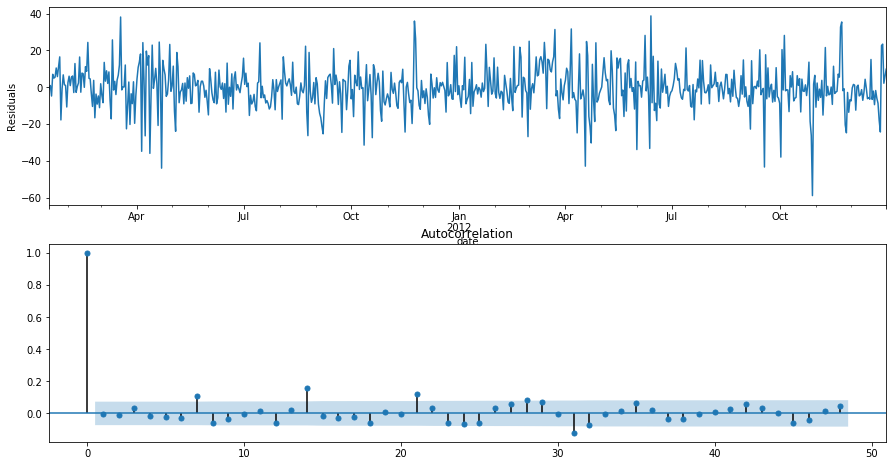

In [26]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием —Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Тьюнга-Кокса и коррелограммой). ѕосмотрим, насколько хорошо модель описывает данные:

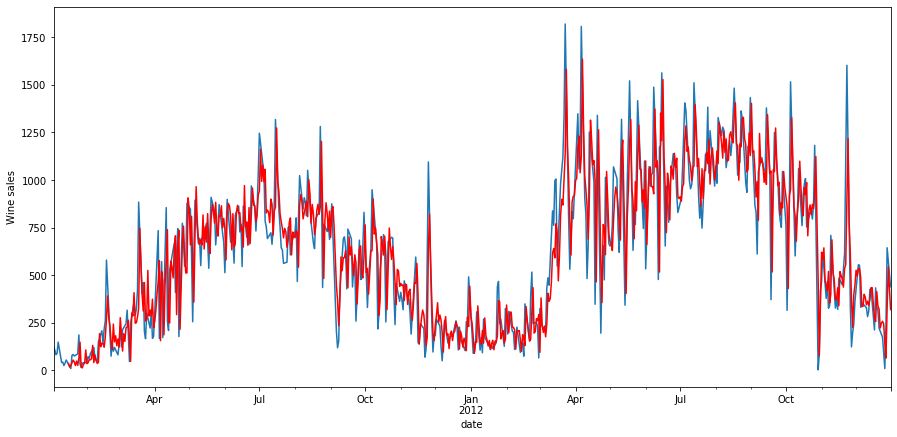

In [28]:
bike['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
bike.count.plot()
bike.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

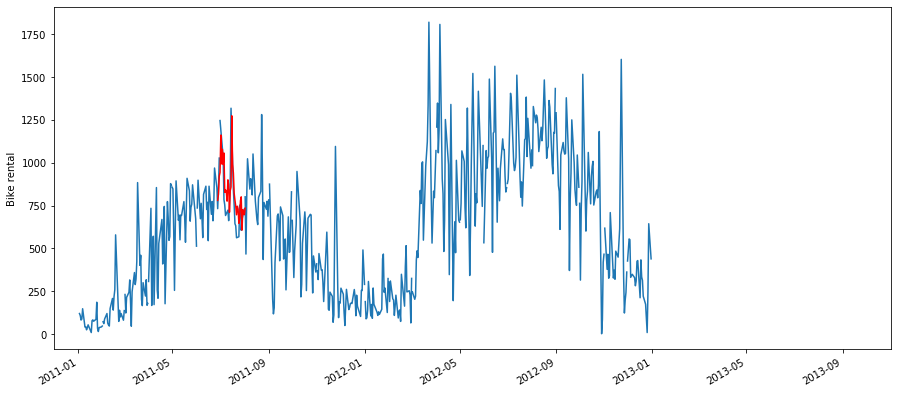

In [36]:
bike_2 = bike[['count']]
date_list = [datetime.datetime.strptime("2010-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= bike_2.columns)
bike_2 = pd.concat([bike_2, future])
bike_2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
bike_2['count'].plot()
bike_2.forecast.plot(color='r')
plt.ylabel('Bike rental')
pylab.show()